In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

import lightgbm as lgb

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Reading the Data

In [3]:
application_train = pd.read_csv('application_train.csv')

application_test = pd.read_csv('application_test.csv')

bureau = pd.read_csv('bureau.csv')

bureau_balance = pd.read_csv('bureau_balance.csv')

credit_card_balance = pd.read_csv('credit_card_balance.csv')

In [4]:
installments_payments = pd.read_csv('installments_payments.csv')

POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')

previous_application = pd.read_csv('previous_application.csv')

# sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
# lets visualize the application_train df first
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
print(f"The shape of application_train df is:  {application_train.shape[0]} rows and {application_train.shape[1]} columns")

The shape of application_train df is:  307511 rows and 122 columns


# The description of each column can be found in the file ‘HomeCredit_columns_description.csv’

## Each dataframe contains 'SK_ID_CURR' as a common column apart from 'Target'.
## 'Target' column has two classes where 0: Loan is repaid and 1: Load is not repaid.

# Now, let's focus on the 'application_train first.

### Checking the missing values in the application_train df

In [7]:
# removing max limit to see columns and rows of df
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
missing_count = application_train.isna().sum().sort_values(ascending = False)
missing_count

COMMONAREA_MEDI                 214865
COMMONAREA_AVG                  214865
COMMONAREA_MODE                 214865
NONLIVINGAPARTMENTS_MODE        213514
NONLIVINGAPARTMENTS_AVG         213514
NONLIVINGAPARTMENTS_MEDI        213514
FONDKAPREMONT_MODE              210295
LIVINGAPARTMENTS_MODE           210199
LIVINGAPARTMENTS_AVG            210199
LIVINGAPARTMENTS_MEDI           210199
FLOORSMIN_AVG                   208642
FLOORSMIN_MODE                  208642
FLOORSMIN_MEDI                  208642
YEARS_BUILD_MEDI                204488
YEARS_BUILD_MODE                204488
YEARS_BUILD_AVG                 204488
OWN_CAR_AGE                     202929
LANDAREA_MEDI                   182590
LANDAREA_MODE                   182590
LANDAREA_AVG                    182590
BASEMENTAREA_MEDI               179943
BASEMENTAREA_AVG                179943
BASEMENTAREA_MODE               179943
EXT_SOURCE_1                    173378
NONLIVINGAREA_MODE              169682
NONLIVINGAREA_AVG        

* There are huge missing values. Let's convert these into percentages to decide how to handle them.

In [9]:
percentage = (application_train.isna().sum()/len(application_train) * 100).sort_values(ascending= False)

In [10]:
# concatanating the count and percentage columns into one to get the single df
missing_df = pd.concat([missing_count, percentage], axis= 1, keys= ['Count', 'Percentage'])
missing_df

,Count,Percentage
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953


<AxesSubplot:>

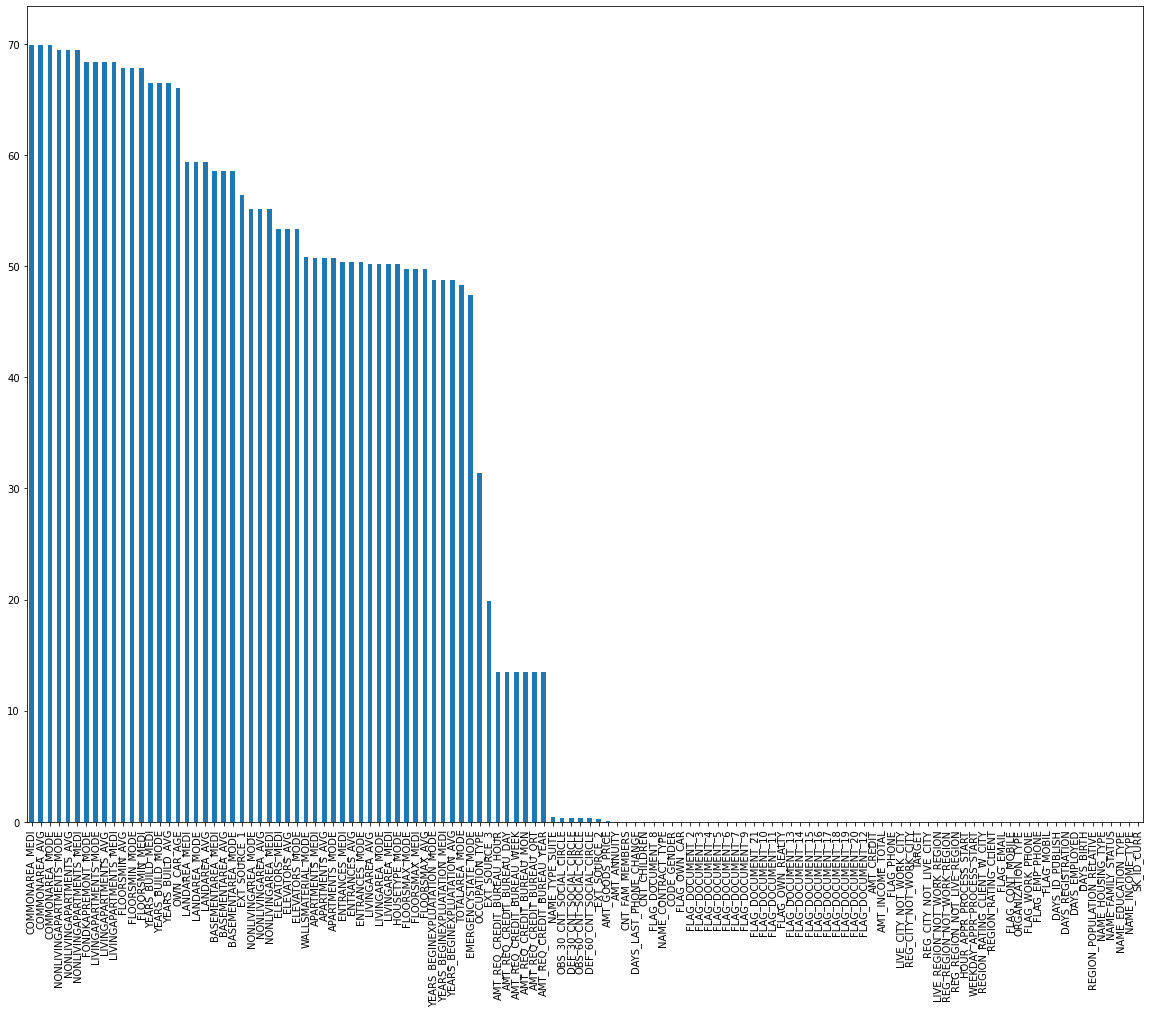

In [11]:
plt.figure(figsize=(20, 15))
missing_df['Percentage'].plot.bar()

* There are around 30 columns which have more than 50% null values. This is huge. Before handing the missing values, let's check for duplicates as this may affect the imputation.

In [12]:
# getting the list of columns in the application_train data
columns = [col for col in application_train.columns if col!='SK_ID_CURR']

application_train[application_train.duplicated(subset = columns)]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR


### There are no duplicates in the application_train datset.

# EDA + Feature Engineering

* Generally, EDA is initiated from TARGET column as this helps in understanding whether the dataset is balanced or not.

In [13]:
plt.rcParams['figure.figsize'] = 12, 8

Text(0.5, 1.0, 'Pie chart distribution of Target Classes')

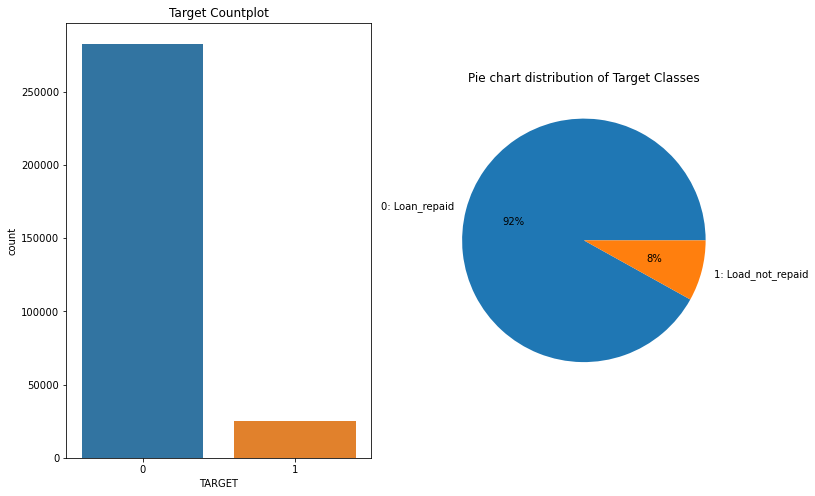

In [14]:
plt.subplot(1, 2, 1)
sns.countplot(application_train['TARGET']);
plt.title('Target Countplot')
# plt.grid(True)

plt.subplot(1, 2, 2)
plt.pie(application_train['TARGET'].value_counts(), labels = ['0: Loan_repaid', '1: Load_not_repaid'], autopct='%.0f%%');
plt.title('Pie chart distribution of Target Classes')

* The above graph shows that dataset is highly imbalanced.

In [15]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# AMT_INCOME_TOTAL

In [16]:
application_train['AMT_INCOME_TOTAL'].value_counts()

1.350000e+05    35750
1.125000e+05    31019
1.575000e+05    26556
1.800000e+05    24719
9.000000e+04    22483
2.250000e+05    20698
2.025000e+05    16341
6.750000e+04    11147
2.700000e+05    10827
8.100000e+04     6001
3.150000e+05     5862
2.475000e+05     5344
1.260000e+05     4668
3.600000e+05     4115
1.215000e+05     3848
9.900000e+04     3633
2.925000e+05     3418
1.035000e+05     3330
7.650000e+04     3146
1.440000e+05     3123
1.710000e+05     2647
4.500000e+05     2435
1.170000e+05     2390
5.400000e+04     2319
7.200000e+04     2187
1.665000e+05     2053
4.500000e+04     2043
1.080000e+05     1946
3.375000e+05     1790
9.450000e+04     1747
1.620000e+05     1702
1.890000e+05     1691
4.050000e+05     1660
8.550000e+04     1514
1.485000e+05     1486
2.160000e+05     1406
1.305000e+05     1256
5.850000e+04     1182
6.300000e+04     1145
1.935000e+05     1061
1.530000e+05     1012
2.115000e+05      985
3.825000e+05      966
1.395000e+05      834
1.755000e+05      800
5.400000e+

<Figure size 1440x1080 with 0 Axes>

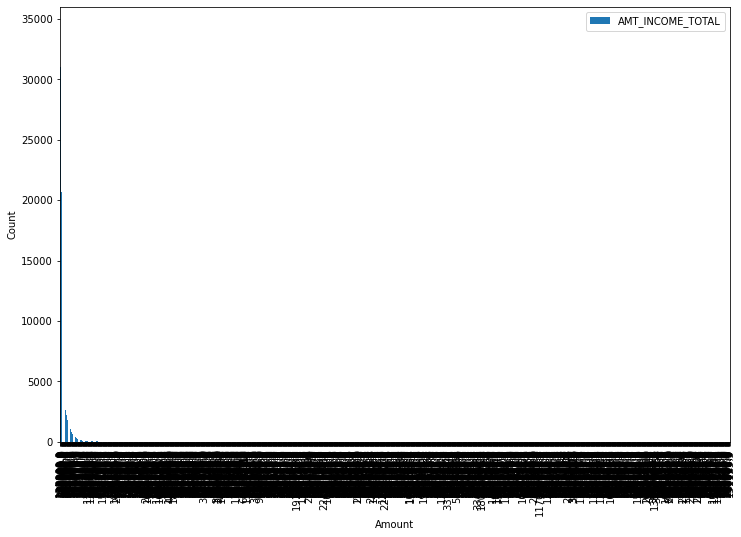

In [17]:
plt.figure(figsize=(20,15))
pd.DataFrame(application_train['AMT_INCOME_TOTAL'].value_counts()).plot.bar();
plt.ylim(0, 36000)

plt.xlabel('Amount');
plt.ylabel('Count');

* From the above graph, its seen that the distribution is highly right skewed. Hence, we can use log normal distribution.

# NAME_CONTRACT_TYPE

In [18]:
application_train['NAME_CONTRACT_TYPE'].unique()

array(['Cash loans', 'Revolving loans'], dtype=object)

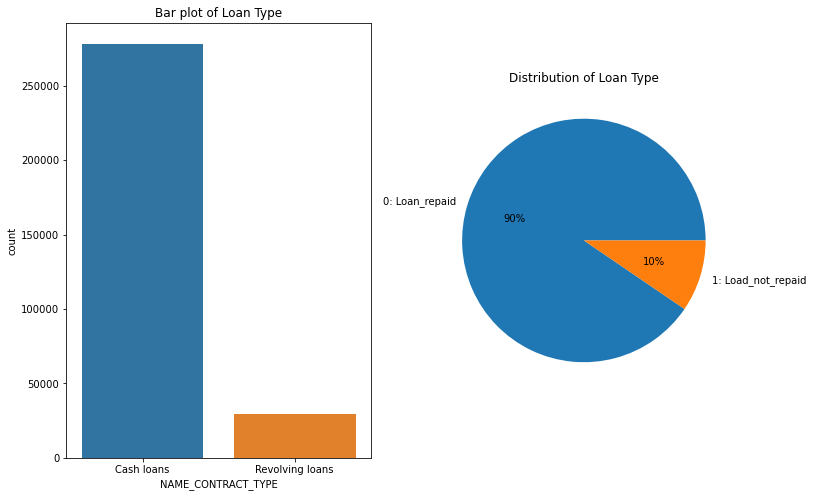

In [19]:
plt.subplot(1, 2, 1)
sns.countplot(application_train['NAME_CONTRACT_TYPE']);
plt.title('Bar plot of Loan Type');

plt.subplot(1, 2, 2)
plt.pie(application_train['NAME_CONTRACT_TYPE'].value_counts(), labels = ['0: Loan_repaid', '1: Load_not_repaid'], 
        autopct='%.0f%%');
plt.title('Distribution of Loan Type');

* People have taken more cash loans than revolving loans i.e. people are more interested in cash loans than revolving loans.

In [20]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# AMT_CREDIT

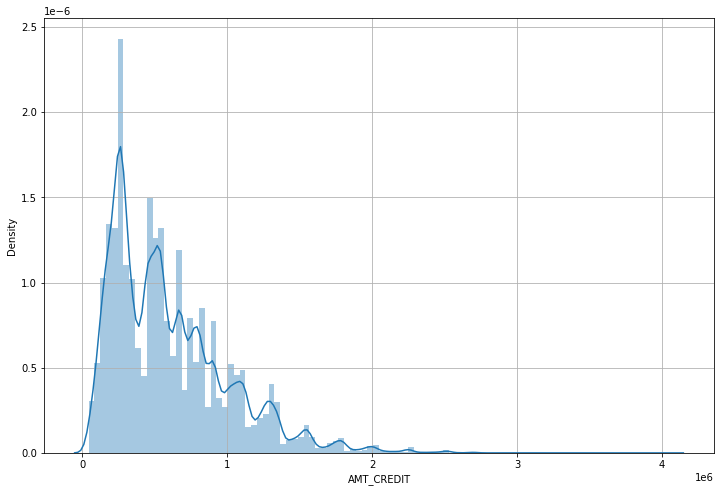

In [21]:
sns.distplot(application_train['AMT_CREDIT'], bins = 100);
plt.grid(True)

<AxesSubplot:>

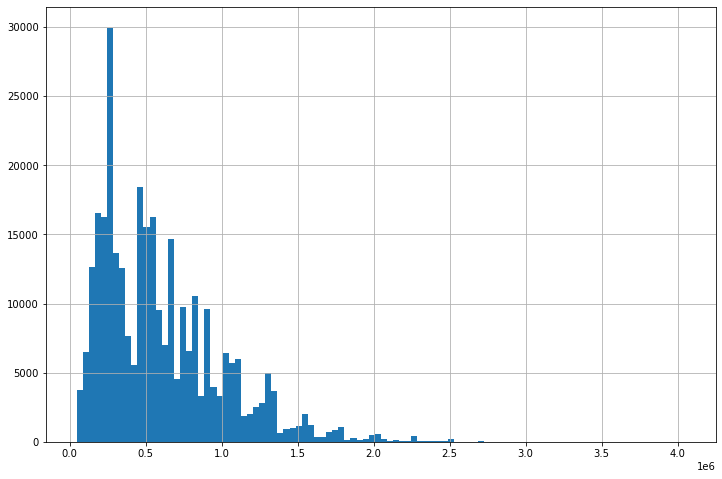

In [22]:
application_train['AMT_CREDIT'].hist(bins = 100)

<AxesSubplot:>

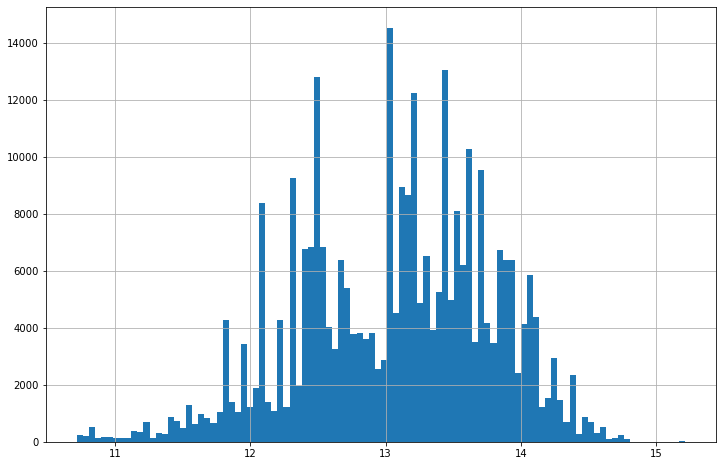

In [23]:
np.log(application_train['AMT_CREDIT']).hist(bins = 100)


# NAME_TYPE_SUITE

In [24]:
application_train['NAME_TYPE_SUITE'].unique()

array(['Unaccompanied', 'Family', 'Spouse, partner', 'Children',
       'Other_A', nan, 'Other_B', 'Group of people'], dtype=object)

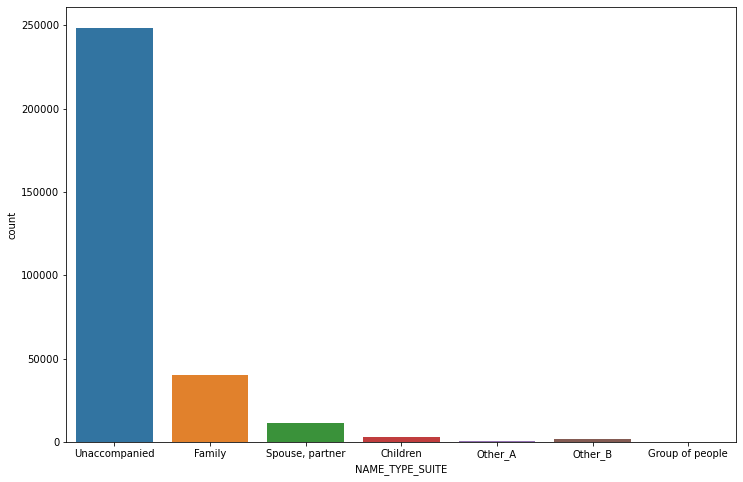

In [25]:
sns.countplot(application_train['NAME_TYPE_SUITE']);

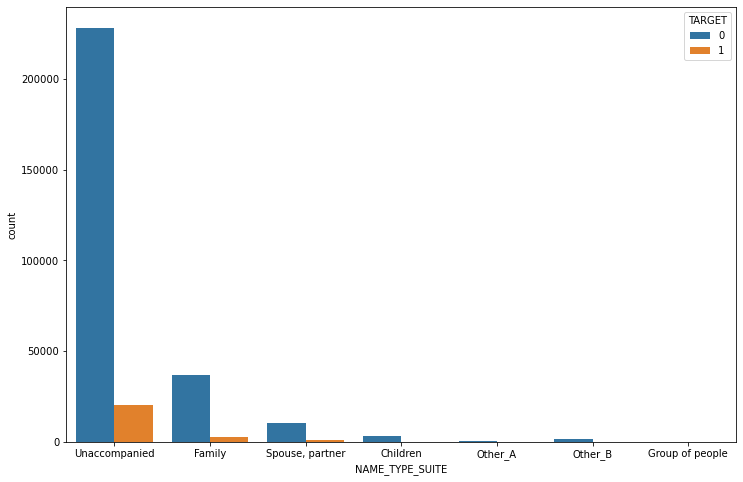

In [26]:
sns.countplot(application_train['NAME_TYPE_SUITE'], hue =application_train['TARGET']);

* Highest number of applications are from Unaccompained people. Also, these are the highest number of people who have paid the the loan.

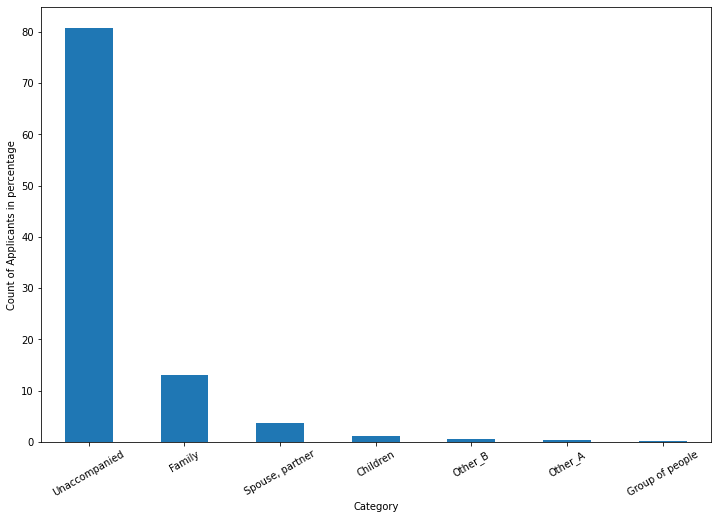

In [27]:
((application_train['NAME_TYPE_SUITE'].value_counts()/len(application_train)) * 100).plot.bar();
plt.xticks(rotation=30);
plt.xlabel('Category');
plt.ylabel('Count of Applicants in percentage');

In [28]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# NAME_INCOME_TYPE

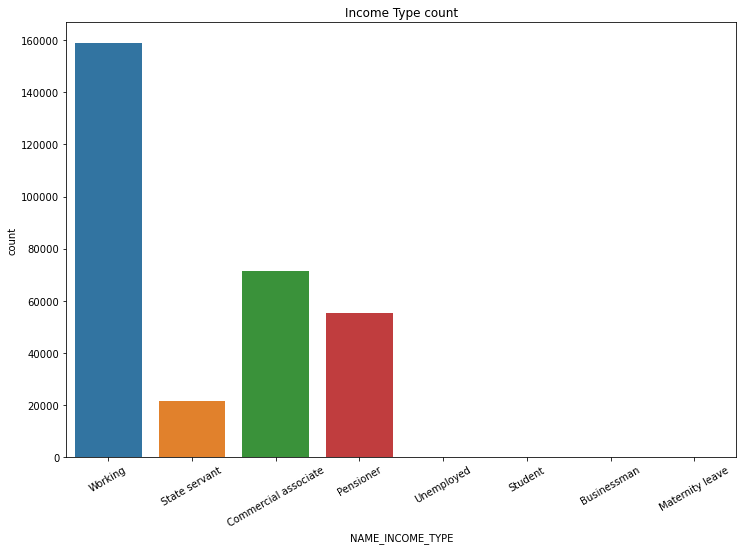

In [29]:
sns.countplot(application_train['NAME_INCOME_TYPE']);
plt.xticks(rotation=30);
plt.title('Income Type count');

* Working people are amongst the highest applicants.

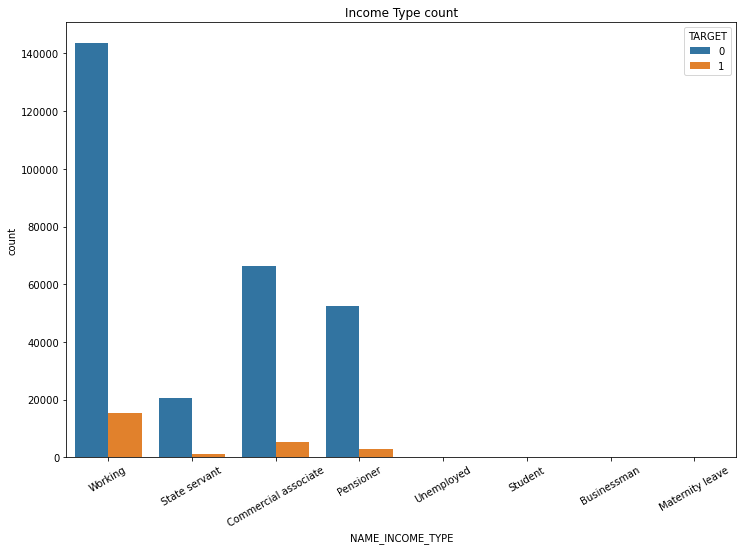

In [30]:
sns.countplot(application_train['NAME_INCOME_TYPE'], hue = application_train['TARGET']);
plt.xticks(rotation=30);
plt.title('Income Type count');

* Working people are highest in number in terms of loan repayment.

# NAME_EDUCATION_TYPE

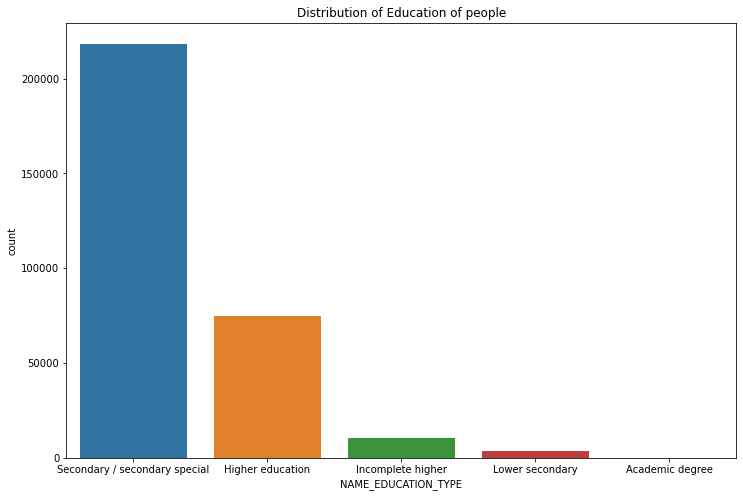

In [31]:
sns.countplot(application_train['NAME_EDUCATION_TYPE']);
plt.title('Distribution of Education of people');

* People with Secondary/Secondary special education status tend to apply for loan more than any other educational type.

# NAME_HOUSING_TYPE

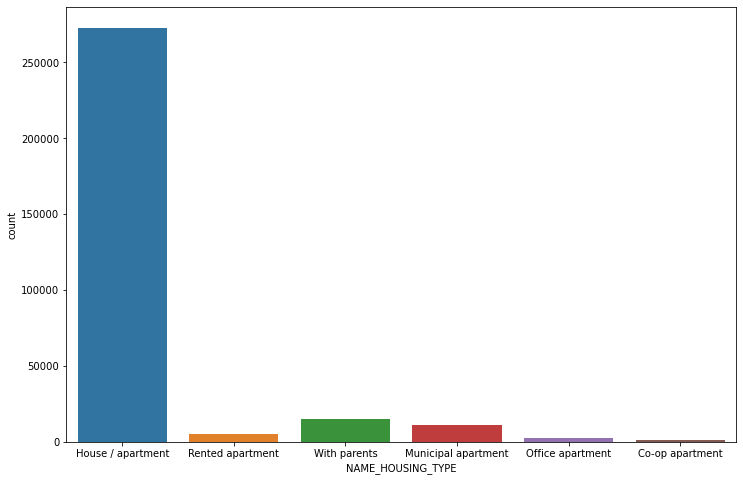

In [32]:
sns.countplot(application_train['NAME_HOUSING_TYPE']);

* People living in houses/apartments have applied for loans more than any other house types.

# DAYS_BIRTH

In [33]:
application_train['DAYS_BIRTH'].value_counts()

-13749    43
-13481    42
-10020    41
-18248    41
-15771    40
-10292    40
-14267    39
-14395    39
-11664    39
-13263    39
-13480    38
-13891    38
-14791    38
-13634    38
-13788    38
-13584    38
-15042    38
-15565    38
-16690    37
-14767    37
-15450    37
-12806    37
-15048    37
-14276    37
-10136    37
-10107    37
-20074    37
-14790    37
-15563    37
-14890    37
-11108    37
-16257    37
-13217    37
-10192    37
-13904    36
-14386    36
-10519    36
-14137    36
-15322    36
-13643    36
-13708    36
-11524    36
-14776    36
-13706    36
-14926    36
-13271    36
-14131    35
-14297    35
-14120    35
-16490    35
-14384    35
-16185    35
-13254    35
-14825    35
-11588    35
-12682    35
-11135    35
-15164    35
-10213    35
-12433    35
-15155    35
-14350    35
-16830    35
-11266    35
-15044    35
-15901    35
-10088    35
-17873    35
-10223    35
-11097    35
-13273    35
-13922    35
-14099    35
-12776    35
-15073    35
-13687    35
-15009    35

* The age of the people applied for loans are given in days. Let's convert this age into year by dividing by 365.
* Here, all values are negative. This could be some error so we will divide by -365 to get age values in positive.

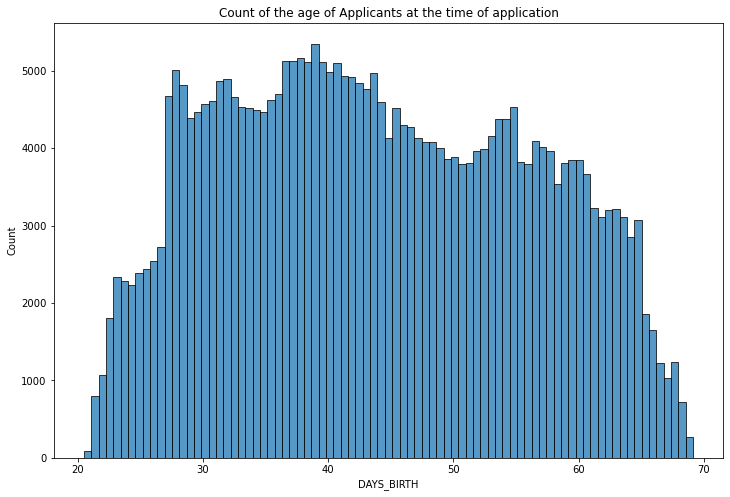

In [34]:
sns.histplot(application_train['DAYS_BIRTH']/(-365));
# plt.grid(True)
plt.title('Count of the age of Applicants at the time of application');

* The applicants are between 20 to 70 age group where highest applicants belong to late 30's age group.

In [35]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# DAYS_EMPLOYED

Text(0.5, 1.0, 'Days before the application the person started current employment')

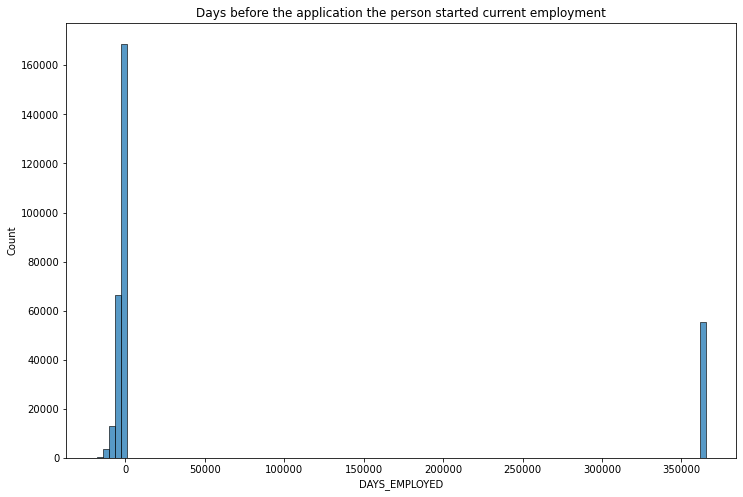

In [36]:
sns.histplot(application_train['DAYS_EMPLOYED'], bins = 100);
plt.title('Days before the application the person started current employment')

* We have -1000.66 years(-365243 days) of employment which is impossible. Looks like there is data entry error.

In [37]:
# calculating the total error values
error = application_train[application_train['DAYS_EMPLOYED'] == 365243]
print('The no of errors are :', len(error))

(error['TARGET'].value_counts()/len(error))*100

The no of errors are : 55374


0    94.600354
1     5.399646
Name: TARGET, dtype: float64

In [38]:
# Replace the error values with nan
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

In [39]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

Text(0.5, 1.0, 'Daywise count of the employed people applying for loan')

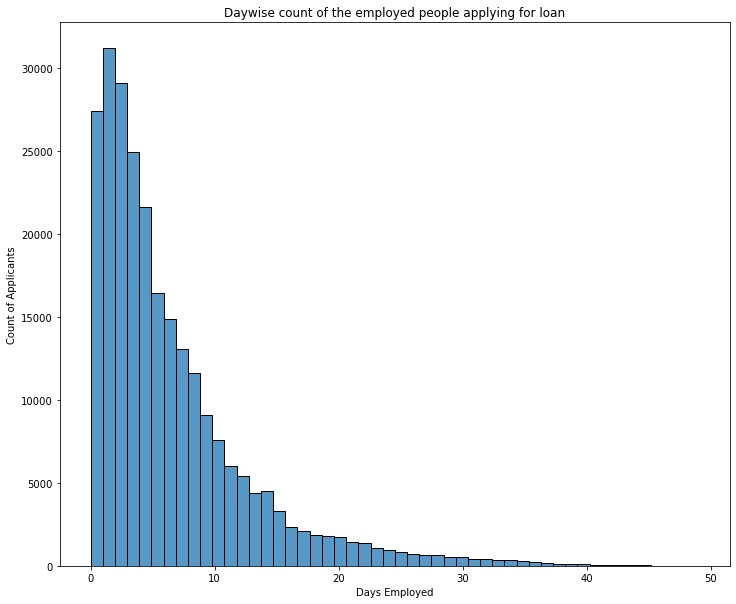

In [40]:
plt.rcParams['figure.figsize'] = 12, 10
sns.histplot((application_train['DAYS_EMPLOYED']/(-365)), bins=50);
plt.xlabel('Days Employed');
plt.ylabel('Count of Applicants');

plt.title('Daywise count of the employed people applying for loan')

# Data Preparation:

* Let's check if there are any applicants whose total income is greater than credit

In [41]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [42]:
application_train.shape

(307511, 122)

In [43]:
application_train['Income_Greater_than_Credit'] = application_train['AMT_INCOME_TOTAL'] > application_train['AMT_CREDIT']

In [44]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Income_Greater_than_Credit
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

# Let's create column to represent Income Credit  Percent.
* Converting into Percent will help us in comparing the data amongst different applicants.

In [45]:
application_train['INCOME_CREDIT_PERCENT'] = application_train['AMT_CREDIT'] / application_train['AMT_INCOME_TOTAL']

In [46]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Income_Greater_than_Credit,INCOME_CREDIT_PERCENT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False,2.007889
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False,4.790750
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

# Creating a column to represent Annuity Income in percentage

In [47]:
application_train['ANNUITY_INCOME_PERCENT'] = application_train['AMT_ANNUITY'] / application_train['AMT_INCOME_TOTAL']

In [48]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Income_Greater_than_Credit,INCOME_CREDIT_PERCENT,ANNUITY_INCOME_PERCENT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False,2.007889,0.121978
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False,4.790750,0.132217
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.72956

# Creating a column to represent Credit Term

In [49]:
application_train['CREDIT_TERM'] = application_train['AMT_CREDIT'] / application_train['AMT_ANNUITY'] 

# Column to represent percent of days employed  in his life

In [50]:
application_train['DAYS_EMPLOYED_PERCENT'] = application_train['DAYS_EMPLOYED'] / application_train['DAYS_BIRTH']

* The above columns are created using the percentage as this will help in comparing the data in a better way.
* After creating all columns, the shape of the application_train dataset is:

In [51]:
print(f'The shape of the applicatin_train dataset is {application_train.shape[0]} rows and {application_train.shape[1]}')

The shape of the applicatin_train dataset is 307511 rows and 127


In [52]:
application_train.isna().sum()

SK_ID_CURR                           0
TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                    55374
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     202929
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE         

# Bureau Data

In [53]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [54]:
print(f'The shape of bureau data is : {bureau.shape[0]} rows and {bureau.shape[1]} columns.')

The shape of bureau data is : 1716428 rows and 17 columns.


In [55]:
bureau.isna().sum()

SK_ID_CURR                      0
SK_ID_BUREAU                    0
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM                 13
AMT_CREDIT_SUM_DEBT        257669
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
AMT_ANNUITY               1226791
dtype: int64

* If we observe carefully, we can see 'SK_ID_CURR' as a common column in application_train dataset and bureau dataset.

In [56]:
group = bureau.drop(['SK_ID_BUREAU'], axis = 1).groupby(by=['SK_ID_CURR']).mean().reset_index()

In [57]:
group.head()

,SK_ID_CURR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100001,-735.000000,0.0,82.428571,-825.500000,NaN,0.0,207623.571429,85240.928571,0.00000,0.0,-93.142857,3545.357143
1,100002,-874.000000,0.0,-349.000000,-697.500000,1681.029,0.0,108131.945625,49156.200000,7997.14125,0.0,-499.875000,0.000000
2,100003,-1400.750000,0.0,-544.500000,-1097.333333,0.000,0.0,254350.125000,0.000000,202500.00000,0.0,-816.000000,NaN
3,100004,-867.000000,0.0,-488.500000,-532.500000,0.000,0.0,94518.900000,0.000000,0.00000,0.0,-532.000000,NaN
4,100005,-190.666667,0.0,439.333333,-123.000000,0.000,0.0,219042.000000,189469.500000,0.00000,0.0,-54.333333,1420.500000


In [58]:
# renaming the bureanu columns to indentify them explicitely
group.columns = ['BUREAU_'+column if column !='SK_ID_CURR' else column for column in group.columns]

In [59]:
group.head()

,SK_ID_CURR,BUREAU_DAYS_CREDIT,BUREAU_CREDIT_DAY_OVERDUE,BUREAU_DAYS_CREDIT_ENDDATE,BUREAU_DAYS_ENDDATE_FACT,BUREAU_AMT_CREDIT_MAX_OVERDUE,BUREAU_CNT_CREDIT_PROLONG,BUREAU_AMT_CREDIT_SUM,BUREAU_AMT_CREDIT_SUM_DEBT,BUREAU_AMT_CREDIT_SUM_LIMIT,BUREAU_AMT_CREDIT_SUM_OVERDUE,BUREAU_DAYS_CREDIT_UPDATE,BUREAU_AMT_ANNUITY
0,100001,-735.000000,0.0,82.428571,-825.500000,NaN,0.0,207623.571429,85240.928571,0.00000,0.0,-93.142857,3545.357143
1,100002,-874.000000,0.0,-349.000000,-697.500000,1681.029,0.0,108131.945625,49156.200000,7997.14125,0.0,-499.875000,0.000000
2,100003,-1400.750000,0.0,-544.500000,-1097.333333,0.000,0.0,254350.125000,0.000000,202500.00000,0.0,-816.000000,NaN
3,100004,-867.000000,0.0,-488.500000,-532.500000,0.000,0.0,94518.900000,0.000000,0.00000,0.0,-532.000000,NaN
4,100005,-190.666667,0.0,439.333333,-123.000000,0.000,0.0,219042.000000,189469.500000,0.00000,0.0,-54.333333,1420.500000


### Combining application_train dataset and bureau dataset
* We need only thosew customers whose data is present in application_train dataset. So, we will perform left outer join or simply left join

In [60]:
application_bureau = application_train.merge(group, on='SK_ID_CURR', how='left')

In [61]:
# checking dimensions
application_bureau.shape

(307511, 139)

In [62]:
application_train.shape

(307511, 127)

In [63]:
application_bureau.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Income_Greater_than_Credit,INCOME_CREDIT_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,BUREAU_DAYS_CREDIT,BUREAU_CREDIT_DAY_OVERDUE,BUREAU_DAYS_CREDIT_ENDDATE,BUREAU_DAYS_ENDDATE_FACT,BUREAU_AMT_CREDIT_MAX_OVERDUE,BUREAU_CNT_CREDIT_PROLONG,BUREAU_AMT_CREDIT_SUM,BUREAU_AMT_CREDIT_SUM_DEBT,BUREAU_AMT_CREDIT_SUM_LIMIT,BUREAU_AMT_CREDIT_SUM_OVERDUE,BUREAU_DAYS_CREDIT_UPDATE,BUREAU_AMT_ANNUITY
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False,2.007889,0.121978,16.461104,0.067329,-874.00,0.0,-349.0,-697.500000,1681.029,0.0,108131.945625,49156.2,7997.14125,0.0,-499.875,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0

In [64]:
# filling the missing values with 0
# application_bureau.update(application_bureau[group.columns].fillna(0))

In [65]:
application_bureau.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Income_Greater_than_Credit,INCOME_CREDIT_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,BUREAU_DAYS_CREDIT,BUREAU_CREDIT_DAY_OVERDUE,BUREAU_DAYS_CREDIT_ENDDATE,BUREAU_DAYS_ENDDATE_FACT,BUREAU_AMT_CREDIT_MAX_OVERDUE,BUREAU_CNT_CREDIT_PROLONG,BUREAU_AMT_CREDIT_SUM,BUREAU_AMT_CREDIT_SUM_DEBT,BUREAU_AMT_CREDIT_SUM_LIMIT,BUREAU_AMT_CREDIT_SUM_OVERDUE,BUREAU_DAYS_CREDIT_UPDATE,BUREAU_AMT_ANNUITY
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False,2.007889,0.121978,16.461104,0.067329,-874.00,0.0,-349.0,-697.500000,1681.029,0.0,108131.945625,49156.2,7997.14125,0.0,-499.875,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0

In [66]:
# creating one hot encoding for categorical features
bureau_categorical = pd.get_dummies(bureau.select_dtypes('object'), )
bureau_categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']

In [67]:
bureau_categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,215354


In [68]:
group = bureau_categorical.groupby(by = ['SK_ID_CURR']).mean().reset_index()
group.columns = ['BUREAU_'+column if column !='SK_ID_CURR' else column for column in group.columns]
application_bureau = application_bureau.merge(group, on='SK_ID_CURR', how='left')

In [69]:
application_bureau.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Income_Greater_than_Credit,INCOME_CREDIT_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,BUREAU_DAYS_CREDIT,BUREAU_CREDIT_DAY_OVERDUE,BUREAU_DAYS_CREDIT_ENDDATE,BUREAU_DAYS_ENDDATE_FACT,BUREAU_AMT_CREDIT_MAX_OVERDUE,BUREAU_CNT_CREDIT_PROLONG,BUREAU_AMT_CREDIT_SUM,BUREAU_AMT_CREDIT_SUM_DEBT,BUREAU_AMT_CREDIT_SUM_LIMIT,BUREAU_AMT_CREDIT_SUM_OVERDUE,BUREAU_DAYS_CREDIT_UPDATE,BUREAU_AMT_ANNUITY,BUREAU_CREDIT_ACTIVE_Active,BUREAU_CREDIT_ACTIVE_Bad debt,BUREAU_CREDIT_ACTIVE_Closed,BUREAU_CREDIT_ACTIVE_Sold,BUREAU_CREDIT_CURRENCY_currency 1,BUREAU_CREDIT_CURRENCY_currency 2,BUREAU_CREDIT_CURRENCY_currency 3,BUREAU_CREDIT_CURRENCY_currency 4,BUREAU_CREDIT_TYPE_Another type of loan,BUREAU_CREDIT_TYPE_Car loan,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked),BUREAU_CREDIT_TYPE_Consumer credit,BUREAU_CREDIT_TYPE_Credit card,BUREAU_CREDIT_TYPE_Interbank credit,BUREAU_CREDIT_TYPE_Loan for business development,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending),BUREAU_CREDIT_TYPE_Loan for the purchase of equipment,BUREAU_CREDIT_TYPE_Loan for working capital replenishment,BUREAU_CREDIT_TYPE_Microloan,BUREAU_CREDIT_TYPE_Mobile operator loan,BUREAU_CREDIT_TYPE_Mortgage,BUREAU_CREDIT_TYPE_Real estate loan,BUREAU_CREDIT_TYPE_Unknown type of loan
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00

In [70]:
# filling the missing values of the categorical data with 0
application_bureau.update(application_bureau[group.columns].fillna(0))

In [71]:
application_bureau.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Income_Greater_than_Credit,INCOME_CREDIT_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,BUREAU_DAYS_CREDIT,BUREAU_CREDIT_DAY_OVERDUE,BUREAU_DAYS_CREDIT_ENDDATE,BUREAU_DAYS_ENDDATE_FACT,BUREAU_AMT_CREDIT_MAX_OVERDUE,BUREAU_CNT_CREDIT_PROLONG,BUREAU_AMT_CREDIT_SUM,BUREAU_AMT_CREDIT_SUM_DEBT,BUREAU_AMT_CREDIT_SUM_LIMIT,BUREAU_AMT_CREDIT_SUM_OVERDUE,BUREAU_DAYS_CREDIT_UPDATE,BUREAU_AMT_ANNUITY,BUREAU_CREDIT_ACTIVE_Active,BUREAU_CREDIT_ACTIVE_Bad debt,BUREAU_CREDIT_ACTIVE_Closed,BUREAU_CREDIT_ACTIVE_Sold,BUREAU_CREDIT_CURRENCY_currency 1,BUREAU_CREDIT_CURRENCY_currency 2,BUREAU_CREDIT_CURRENCY_currency 3,BUREAU_CREDIT_CURRENCY_currency 4,BUREAU_CREDIT_TYPE_Another type of loan,BUREAU_CREDIT_TYPE_Car loan,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked),BUREAU_CREDIT_TYPE_Consumer credit,BUREAU_CREDIT_TYPE_Credit card,BUREAU_CREDIT_TYPE_Interbank credit,BUREAU_CREDIT_TYPE_Loan for business development,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending),BUREAU_CREDIT_TYPE_Loan for the purchase of equipment,BUREAU_CREDIT_TYPE_Loan for working capital replenishment,BUREAU_CREDIT_TYPE_Microloan,BUREAU_CREDIT_TYPE_Mobile operator loan,BUREAU_CREDIT_TYPE_Mortgage,BUREAU_CREDIT_TYPE_Real estate loan,BUREAU_CREDIT_TYPE_Unknown type of loan
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00

In [72]:
# Number of previous loans per customer and renaming SK_ID_BUREAU to bureau loan count
group = bureau.groupby(by = ['SK_ID_CURR'])['SK_ID_BUREAU'].count().reset_index().rename(
                                        columns = {'SK_ID_BUREAU': 'BUREAU_LOAN_COUNT'})

In [73]:
# merging above group with the application_bureau df
application_bureau = application_bureau.merge(group, on='SK_ID_CURR', how='left')

# filling the missing values of newly renamed column to 0
application_bureau['BUREAU_LOAN_COUNT'] = application_bureau['BUREAU_LOAN_COUNT'].fillna(0)

In [74]:
application_bureau.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Income_Greater_than_Credit,INCOME_CREDIT_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,BUREAU_DAYS_CREDIT,BUREAU_CREDIT_DAY_OVERDUE,BUREAU_DAYS_CREDIT_ENDDATE,BUREAU_DAYS_ENDDATE_FACT,BUREAU_AMT_CREDIT_MAX_OVERDUE,BUREAU_CNT_CREDIT_PROLONG,BUREAU_AMT_CREDIT_SUM,BUREAU_AMT_CREDIT_SUM_DEBT,BUREAU_AMT_CREDIT_SUM_LIMIT,BUREAU_AMT_CREDIT_SUM_OVERDUE,BUREAU_DAYS_CREDIT_UPDATE,BUREAU_AMT_ANNUITY,BUREAU_CREDIT_ACTIVE_Active,BUREAU_CREDIT_ACTIVE_Bad debt,BUREAU_CREDIT_ACTIVE_Closed,BUREAU_CREDIT_ACTIVE_Sold,BUREAU_CREDIT_CURRENCY_currency 1,BUREAU_CREDIT_CURRENCY_currency 2,BUREAU_CREDIT_CURRENCY_currency 3,BUREAU_CREDIT_CURRENCY_currency 4,BUREAU_CREDIT_TYPE_Another type of loan,BUREAU_CREDIT_TYPE_Car loan,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked),BUREAU_CREDIT_TYPE_Consumer credit,BUREAU_CREDIT_TYPE_Credit card,BUREAU_CREDIT_TYPE_Interbank credit,BUREAU_CREDIT_TYPE_Loan for business development,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending),BUREAU_CREDIT_TYPE_Loan for the purchase of equipment,BUREAU_CREDIT_TYPE_Loan for working capital replenishment,BUREAU_CREDIT_TYPE_Microloan,BUREAU_CREDIT_TYPE_Mobile operator loan,BUREAU_CREDIT_TYPE_Mortgage,BUREAU_CREDIT_TYPE_Real estate loan,BUREAU_CREDIT_TYPE_Unknown type of loan,BUREAU_LOAN_COUNT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,

# Looking for number of loans per customer by its category

In [75]:
# Number of types of previous loans per customer 
group = bureau[['SK_ID_CURR', 'CREDIT_TYPE']].groupby(by = ['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index().rename(columns={'CREDIT_TYPE': 'BUREAU_LOAN_TYPES'})

In [76]:
# merging above group with application_bureau df
application_bureau = application_bureau.merge(group, on='SK_ID_CURR', how='left')

# filling the missing values with 0
application_bureau['BUREAU_LOAN_TYPES'] = application_bureau['BUREAU_LOAN_TYPES'].fillna(0)

In [77]:
application_bureau.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Income_Greater_than_Credit,INCOME_CREDIT_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,BUREAU_DAYS_CREDIT,BUREAU_CREDIT_DAY_OVERDUE,BUREAU_DAYS_CREDIT_ENDDATE,BUREAU_DAYS_ENDDATE_FACT,BUREAU_AMT_CREDIT_MAX_OVERDUE,BUREAU_CNT_CREDIT_PROLONG,BUREAU_AMT_CREDIT_SUM,BUREAU_AMT_CREDIT_SUM_DEBT,BUREAU_AMT_CREDIT_SUM_LIMIT,BUREAU_AMT_CREDIT_SUM_OVERDUE,BUREAU_DAYS_CREDIT_UPDATE,BUREAU_AMT_ANNUITY,BUREAU_CREDIT_ACTIVE_Active,BUREAU_CREDIT_ACTIVE_Bad debt,BUREAU_CREDIT_ACTIVE_Closed,BUREAU_CREDIT_ACTIVE_Sold,BUREAU_CREDIT_CURRENCY_currency 1,BUREAU_CREDIT_CURRENCY_currency 2,BUREAU_CREDIT_CURRENCY_currency 3,BUREAU_CREDIT_CURRENCY_currency 4,BUREAU_CREDIT_TYPE_Another type of loan,BUREAU_CREDIT_TYPE_Car loan,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked),BUREAU_CREDIT_TYPE_Consumer credit,BUREAU_CREDIT_TYPE_Credit card,BUREAU_CREDIT_TYPE_Interbank credit,BUREAU_CREDIT_TYPE_Loan for business development,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending),BUREAU_CREDIT_TYPE_Loan for the purchase of equipment,BUREAU_CREDIT_TYPE_Loan for working capital replenishment,BUREAU_CREDIT_TYPE_Microloan,BUREAU_CREDIT_TYPE_Mobile operator loan,BUREAU_CREDIT_TYPE_Mortgage,BUREAU_CREDIT_TYPE_Real estate loan,BUREAU_CREDIT_TYPE_Unknown type of loan,BUREAU_LOAN_COUNT,BUREAU_LOAN_TYPES
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0

In [78]:
bureau[['AMT_CREDIT_SUM']].head()

,AMT_CREDIT_SUM
0,91323.0
1,225000.0
2,464323.5
3,90000.0
4,2700000.0


In [79]:
## filling missing values with 0 in Debt over credit ratio 
bureau['AMT_CREDIT_SUM'] = bureau['AMT_CREDIT_SUM'].fillna(0)
bureau['AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].fillna(0)

In [80]:

group1 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM': 'TOTAL_CREDIT_SUM'})

In [81]:
group2 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'TOTAL_CREDIT_SUM_DEBT'})

* Creating new column 'DEBT_CREDIT_RATIO' in group1 df

In [82]:
group1['DEBT_CREDIT_RATIO'] = group2['TOTAL_CREDIT_SUM_DEBT']/group1['TOTAL_CREDIT_SUM']

In [83]:
del group1['TOTAL_CREDIT_SUM']

* Merging application_bureau and group1 to get debt_credit_ratio in the main df

In [84]:
application_bureau = application_bureau.merge(group1, on='SK_ID_CURR', how='left')

# filling the missing values in the newly created column
application_bureau['DEBT_CREDIT_RATIO'] = application_bureau['DEBT_CREDIT_RATIO'].fillna(0)
application_bureau['DEBT_CREDIT_RATIO'] = application_bureau.replace([np.inf, -np.inf], 0)
application_bureau['DEBT_CREDIT_RATIO'] = pd.to_numeric(application_bureau['DEBT_CREDIT_RATIO'], downcast='float')

In [85]:
# creatingnew column called: Overdue over debt ratio 

#fillin missing values in the AMT_CREDIT_SUM_OVERDUE column of bureau and AMT_CREDIT_SUM_DEBT
bureau['AMT_CREDIT_SUM_OVERDUE'] = bureau['AMT_CREDIT_SUM_OVERDUE'].fillna(0)
bureau['AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].fillna(0)

In [86]:
group1 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_OVERDUE']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_OVERDUE'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_OVERDUE': 'TOTAL_CUSTOMER_OVERDUE'})

In [87]:
group2 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'TOTAL_CUSTOMER_DEBT'})

In [88]:
group1['OVERDUE_DEBT_RATIO'] = group1['TOTAL_CUSTOMER_OVERDUE']/group2['TOTAL_CUSTOMER_DEBT']

In [89]:
del group1['TOTAL_CUSTOMER_OVERDUE']

In [90]:
# merging group1 df with application_bureau df

application_bureau = application_bureau.merge(group1, on='SK_ID_CURR', how='left')

# filling missing values with 0
application_bureau['OVERDUE_DEBT_RATIO'] = application_bureau['OVERDUE_DEBT_RATIO'].fillna(0)
application_bureau['OVERDUE_DEBT_RATIO'] = application_bureau.replace([np.inf, -np.inf], 0)

In [91]:
# dtype conversion
application_bureau['OVERDUE_DEBT_RATIO'] = pd.to_numeric(application_bureau['OVERDUE_DEBT_RATIO'], downcast='float')

# Previous Application dataframe

In [92]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
previous_application.shape

(1670214, 37)

* joining application_bureau and previous application data

In [94]:
# Number of previous applications per customer
group = previous_application[['SK_ID_CURR','SK_ID_PREV']].groupby(by=['SK_ID_CURR'])['SK_ID_PREV'].count().reset_index().rename(columns={'SK_ID_PREV':'PREV_APP_COUNT'})


# joining application_bureau and previous application data
application_bureau_prev = application_bureau.merge(group, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev['PREV_APP_COUNT'] = application_bureau_prev['PREV_APP_COUNT'].fillna(0)

In [95]:
application_bureau_prev.shape

(307511, 167)

In [96]:
application_bureau_prev.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Income_Greater_than_Credit,INCOME_CREDIT_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,BUREAU_DAYS_CREDIT,BUREAU_CREDIT_DAY_OVERDUE,BUREAU_DAYS_CREDIT_ENDDATE,BUREAU_DAYS_ENDDATE_FACT,BUREAU_AMT_CREDIT_MAX_OVERDUE,BUREAU_CNT_CREDIT_PROLONG,BUREAU_AMT_CREDIT_SUM,BUREAU_AMT_CREDIT_SUM_DEBT,BUREAU_AMT_CREDIT_SUM_LIMIT,BUREAU_AMT_CREDIT_SUM_OVERDUE,BUREAU_DAYS_CREDIT_UPDATE,BUREAU_AMT_ANNUITY,BUREAU_CREDIT_ACTIVE_Active,BUREAU_CREDIT_ACTIVE_Bad debt,BUREAU_CREDIT_ACTIVE_Closed,BUREAU_CREDIT_ACTIVE_Sold,BUREAU_CREDIT_CURRENCY_currency 1,BUREAU_CREDIT_CURRENCY_currency 2,BUREAU_CREDIT_CURRENCY_currency 3,BUREAU_CREDIT_CURRENCY_currency 4,BUREAU_CREDIT_TYPE_Another type of loan,BUREAU_CREDIT_TYPE_Car loan,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked),BUREAU_CREDIT_TYPE_Consumer credit,BUREAU_CREDIT_TYPE_Credit card,BUREAU_CREDIT_TYPE_Interbank credit,BUREAU_CREDIT_TYPE_Loan for business development,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending),BUREAU_CREDIT_TYPE_Loan for the purchase of equipment,BUREAU_CREDIT_TYPE_Loan for working capital replenishment,BUREAU_CREDIT_TYPE_Microloan,BUREAU_CREDIT_TYPE_Mobile operator loan,BUREAU_CREDIT_TYPE_Mortgage,BUREAU_CREDIT_TYPE_Real estate loan,BUREAU_CREDIT_TYPE_Unknown type of loan,BUREAU_LOAN_COUNT,BUREAU_LOAN_TYPES,DEBT_CREDIT_RATIO,OVERDUE_DEBT_RATIO,PREV_APP_COUNT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,

In [97]:
# Combining numerical features
grp = previous_application.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()

prev_columns = ['PREV_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
application_bureau_prev = application_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

In [98]:
# Combining categorical features
prev_categorical = pd.get_dummies(previous_application.select_dtypes('object'))

prev_categorical['SK_ID_CURR'] = previous_application['SK_ID_CURR']
prev_categorical.head()

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,FLAG_LAST_APPL_PER_CONTRACT_N,FLAG_LAST_APPL_PER_CONTRACT_Y,NAME_CASH_LOAN_PURPOSE_Building a house or an annex,NAME_CASH_LOAN_PURPOSE_Business development,NAME_CASH_LOAN_PURPOSE_Buying a garage,NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land,NAME_CASH_LOAN_PURPOSE_Buying a home,NAME_CASH_LOAN_PURPOSE_Buying a new car,NAME_CASH_LOAN_PURPOSE_Buying a used car,NAME_CASH_LOAN_PURPOSE_Car repairs,NAME_CASH_LOAN_PURPOSE_Education,NAME_CASH_LOAN_PURPOSE_Everyday expenses,NAME_CASH_LOAN_PURPOSE_Furniture,NAME_CASH_LOAN_PURPOSE_Gasification / water supply,NAME_CASH_LOAN_PURPOSE_Hobby,NAME_CASH_LOAN_PURPOSE_Journey,NAME_CASH_LOAN_PURPOSE_Medicine,NAME_CASH_LOAN_PURPOSE_Money for a third person,NAME_CASH_LOAN_PURPOSE_Other,NAME_CASH_LOAN_PURPOSE_Payments on other loans,NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment,NAME_CASH_LOAN_PURPOSE_Refusal to name the goal,NAME_CASH_LOAN_PURPOSE_Repairs,NAME_CASH_LOAN_PURPOSE_Urgent needs,NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday,NAME_CASH_LOAN_PURPOSE_XAP,NAME_CASH_LOAN_PURPOSE_XNA,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cash through the bank,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_GOODS_CATEGORY_Additional Service,NAME_GOODS_CATEGORY_Animals,NAME_GOODS_CATEGORY_Audio/Video,NAME_GOODS_CATEGORY_Auto Accessories,NAME_GOODS_CATEGORY_Clothing and Accessories,NAME_GOODS_CATEGORY_Computers,NAME_GOODS_CATEGORY_Construction Materials,NAME_GOODS_CATEGORY_Consumer Electronics,NAME_GOODS_CATEGORY_Direct Sales,NAME_GOODS_CATEGORY_Education,NAME_GOODS_CATEGORY_Fitness,NAME_GOODS_CATEGORY_Furniture,NAME_GOODS_CATEGORY_Gardening,NAME_GOODS_CATEGORY_Homewares,NAME_GOODS_CATEGORY_House Construction,NAME_GOODS_CATEGORY_Insurance,NAME_GOODS_CATEGORY_Jewelry,NAME_GOODS_CATEGORY_Medical Supplies,NAME_GOODS_CATEGORY_Medicine,NAME_GOODS_CATEGORY_Mobile,NAME_GOODS_CATEGORY_Office Appliances,NAME_GOODS_CATEGORY_Other,NAME_GOODS_CATEGORY_Photo / Cinema Equipment,NAME_GOODS_CATEGORY_Sport and Leisure,NAME_GOODS_CATEGORY_Tourism,NAME_GOODS_CATEGORY_Vehicles,NAME_GOODS_CATEGORY_Weapon,NAME_GOODS_CATEGORY_XNA,NAME_PORTFOLIO_Cards,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,CHANNEL_TYPE_AP+ (Cash loan),CHANNEL_TYPE_Car dealer,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone,NAME_SELLER_INDUSTRY_Auto technology,NAME_SELLER_INDUSTRY_Clothing,NAME_SELLER_INDUSTRY_Connectivity,NAME_SELLER_INDUSTRY_Construction,NAME_SELLER_INDUSTRY_Consumer electronics,NAME_SELLER_INDUSTRY_Furniture,NAME_SELLER_INDUSTRY_Industry,NAME_SELLER_INDUSTRY_Jewelry,NAME_SELLER_INDUSTRY_MLM partners,NAME_SELLER_INDUSTRY_Tourism,NAME_SELLER_INDUSTRY_XNA,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIEL

In [99]:
grp = prev_categorical.groupby('SK_ID_CURR').mean().reset_index()
grp.columns = ['PREV_'+column if column != 'SK_ID_CURR' else column for column in grp.columns]

In [100]:
application_bureau_prev = application_bureau_prev.merge(grp, on=['SK_ID_CURR'], how='left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

# POS_CASH_balance dataset

In [101]:
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [102]:
POS_CASH_balance.shape

(10001358, 8)

In [103]:
# Combining numerical features
grp = POS_CASH_balance.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['POS_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns


In [104]:
# filling missing values with 0
application_bureau_prev = application_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

In [105]:
# Combining categorical features
pos_cash_categorical = pd.get_dummies(POS_CASH_balance.select_dtypes('object'))
pos_cash_categorical['SK_ID_CURR'] = POS_CASH_balance['SK_ID_CURR']

In [106]:
# giving prefix to pos_cash_balance df to identify
group = pos_cash_categorical.groupby('SK_ID_CURR').mean().reset_index()
group.columns = ['POS_'+column if column != 'SK_ID_CURR' else column for column in group.columns]

In [107]:
# merging above categorical df with our main df
application_bureau_prev = application_bureau_prev.merge(group, on=['SK_ID_CURR'], how='left')
application_bureau_prev.update(application_bureau_prev[group.columns].fillna(0))

# installments_payments data

In [108]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [109]:
installments_payments.shape

(13605401, 8)

In [110]:
# Combining numerical features and there are no categorical features in this dataset
group = installments_payments.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['INSTA_'+column if column != 'SK_ID_CURR' else column for column in group.columns ]
group.columns = prev_columns

application_bureau_prev = application_bureau_prev.merge(group, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev.update(application_bureau_prev[group.columns].fillna(0))

# Credit card balance data

In [111]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [112]:
credit_card_balance.shape

(3840312, 23)

In [113]:
credit_card_balance.dtypes

SK_ID_PREV                      int64
SK_ID_CURR                      int64
MONTHS_BALANCE                  int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL         int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT            int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS           object
SK_DPD                          int64
SK_DPD_DEF                      int64
dtype: object

In [114]:
# Combining numerical features
group = credit_card_balance.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['CREDIT_'+column if column != 'SK_ID_CURR' else column for column in group.columns ]
group.columns = prev_columns
application_bureau_prev = application_bureau_prev.merge(group, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev.update(application_bureau_prev[group.columns].fillna(0))

In [115]:
# Combining categorical features
credit_categorical = pd.get_dummies(credit_card_balance.select_dtypes('object'))
credit_categorical['SK_ID_CURR'] = credit_card_balance['SK_ID_CURR']

In [116]:
group = credit_categorical.groupby('SK_ID_CURR').mean().reset_index()
group.columns = ['CREDIT_'+column if column != 'SK_ID_CURR' else column for column in group.columns]

In [117]:
application_bureau_prev = application_bureau_prev.merge(group, on=['SK_ID_CURR'], how='left')
application_bureau_prev.update(application_bureau_prev[group.columns].fillna(0))

In [118]:
application_bureau_prev.shape

(307511, 376)

## With this operation, our data preparation and feature engineering part is completed.

* Separating depepndent and independent features

In [119]:
# dependent variable/target variable
y = application_bureau_prev.pop('TARGET').values

In [120]:
y[:10]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

* We will convert the data into three categories: train, validation and test

In [121]:
X_train, X_temp, y_train, y_temp = train_test_split(application_bureau_prev.drop(['SK_ID_CURR'],axis=1), y, 
                                                    stratify = y, test_size=0.3, random_state=0)


X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify = y_temp, test_size=0.5, random_state=0)
print('Shape of X_train:',X_train.shape)
print('Shape of X_val:',X_val.shape)
print('Shape of X_test:',X_test.shape)

Shape of X_train: (215257, 374)
Shape of X_val: (46127, 374)
Shape of X_test: (46127, 374)


* So far, we haven't treated the missing values. So, let's handle the missing values now.

In [122]:
application_bureau_prev.isna().sum()

SK_ID_CURR                                                               0
NAME_CONTRACT_TYPE                                                       0
CODE_GENDER                                                              0
FLAG_OWN_CAR                                                             0
FLAG_OWN_REALTY                                                          0
CNT_CHILDREN                                                             0
AMT_INCOME_TOTAL                                                         0
AMT_CREDIT                                                               0
AMT_ANNUITY                                                             12
AMT_GOODS_PRICE                                                        278
NAME_TYPE_SUITE                                                       1292
NAME_INCOME_TYPE                                                         0
NAME_EDUCATION_TYPE                                                      0
NAME_FAMILY_STATUS       

In [123]:
# Seperation of columns into numeric and categorical columns
dtypes = np.array([dt for dt in X_train.dtypes])
all_columns = X_train.columns.values
is_num = dtypes != 'object'
num_cols = all_columns[is_num]
cat_cols = all_columns[~is_num]

In [124]:
X_train.columns.values

array(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG',
       'BASE

In [125]:
# Featurization of numeric data
# we will impute with the median data as median is least affected by multiple outliers
imputer_num = SimpleImputer(strategy='median')
X_train_num = imputer_num.fit_transform(X_train[num_cols])
X_val_num = imputer_num.transform(X_val[num_cols])
X_test_num = imputer_num.transform(X_test[num_cols])

In [126]:
# standardizing the values
scaler_num = StandardScaler()
X_train_num1 = scaler_num.fit_transform(X_train_num)
X_val_num1 = scaler_num.transform(X_val_num)
X_test_num1 = scaler_num.transform(X_test_num)

In [127]:
# converting the final imputed dfs into dataframes for future use
X_train_num_final = pd.DataFrame(X_train_num1, columns=num_cols)
X_val_num_final = pd.DataFrame(X_val_num1, columns=num_cols)
X_test_num_final = pd.DataFrame(X_test_num1, columns=num_cols)

In [128]:
# Featurization of categorical data
imputer_cat = SimpleImputer(strategy='constant', fill_value='MISSING')
X_train_cat = imputer_cat.fit_transform(X_train[cat_cols])
X_val_cat = imputer_cat.transform(X_val[cat_cols])
X_test_cat = imputer_cat.transform(X_test[cat_cols])

In [129]:
X_train_cat1= pd.DataFrame(X_train_cat, columns=cat_cols)
X_val_cat1= pd.DataFrame(X_val_cat, columns=cat_cols)
X_test_cat1= pd.DataFrame(X_test_cat, columns=cat_cols)

In [130]:
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
X_train_cat2 = ohe.fit_transform(X_train_cat1)
X_val_cat2 = ohe.transform(X_val_cat1)
X_test_cat2 = ohe.transform(X_test_cat1)

In [131]:
cat_cols_ohe = list(ohe.get_feature_names(input_features=cat_cols))

In [132]:
cat_cols_ohe

['NAME_CONTRACT_TYPE_Cash loans',
 'NAME_CONTRACT_TYPE_Revolving loans',
 'CODE_GENDER_F',
 'CODE_GENDER_M',
 'CODE_GENDER_XNA',
 'FLAG_OWN_CAR_N',
 'FLAG_OWN_CAR_Y',
 'FLAG_OWN_REALTY_N',
 'FLAG_OWN_REALTY_Y',
 'NAME_TYPE_SUITE_Children',
 'NAME_TYPE_SUITE_Family',
 'NAME_TYPE_SUITE_Group of people',
 'NAME_TYPE_SUITE_MISSING',
 'NAME_TYPE_SUITE_Other_A',
 'NAME_TYPE_SUITE_Other_B',
 'NAME_TYPE_SUITE_Spouse, partner',
 'NAME_TYPE_SUITE_Unaccompanied',
 'NAME_INCOME_TYPE_Businessman',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_Maternity leave',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Student',
 'NAME_INCOME_TYPE_Unemployed',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Academic degree',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Incomplete higher',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NAME_FAMILY_STATUS_Civil marriage',
 'NAME_FAMILY_STATUS

In [133]:
X_train_cat_final = pd.DataFrame(X_train_cat2, columns = cat_cols_ohe)
X_val_cat_final = pd.DataFrame(X_val_cat2, columns = cat_cols_ohe)
X_test_cat_final = pd.DataFrame(X_test_cat2, columns = cat_cols_ohe)

In [134]:
# Final complete data
X_train_final = pd.concat([X_train_num_final,X_train_cat_final], axis = 1)
X_val_final = pd.concat([X_val_num_final,X_val_cat_final], axis = 1)
X_test_final = pd.concat([X_test_num_final,X_test_cat_final], axis = 1)
print(X_train_final.shape)
print(X_val_final.shape)
print(X_test_final.shape)

(215257, 504)
(46127, 504)
(46127, 504)


In [135]:
# Saving the Dataframes into CSV files for future use
X_train_final.to_csv('X_train_final.csv')
X_val_final.to_csv('X_val_final.csv')
X_test_final.to_csv('X_test_final.csv')
# Saving the numpy arrays into text files for future use
np.savetxt('y.txt', y)
np.savetxt('y_train.txt', y_train)
np.savetxt('y_val.txt', y_val)
np.savetxt('y_test.txt', y_test)

# LightGBM Classifier Algorithm
* We will use this algoithm first as this is capable of handling the hust datasets. Our dataset has around three million entries so we will use this algorithm first and then we will go for the other algorithms.

In [137]:
model_sk = lgb.LGBMClassifier(boosting_type='gbdt', max_depth=7, learning_rate=0.01, n_estimators= 2000, 
                 class_weight='balanced', n_jobs=-1)

In [138]:
trainFeatures, validFeatures, trainY, validY = train_test_split(X_train_final, y_train, 
                                                                    test_size = 0.15, 
                                                                    random_state = 0)

In [139]:
model_sk.fit(trainFeatures, trainY, 
#              early_stopping_rounds=100, 
             eval_set = [(validFeatures, validY)], 
             eval_metric = 'auc')

LightGBMError: Do not support special JSON characters in feature name.

# The above error is due to the naming convention in our dataset. The dataset columns contain '_' symbol which is not supported by lightgbm algo.
# Now, we will replace the column names

In [170]:
columns = validFeatures.columns

new_columns = []

for column in columns:
    new_columns.append(column.replace(':', ''))

In [171]:
new_columns

['CNTCHILDREN',
 'AMTINCOMETOTAL',
 'AMTCREDIT',
 'AMTANNUITY',
 'AMTGOODSPRICE',
 'REGIONPOPULATIONRELATIVE',
 'DAYSBIRTH',
 'DAYSEMPLOYED',
 'DAYSREGISTRATION',
 'DAYSIDPUBLISH',
 'OWNCARAGE',
 'FLAGMOBIL',
 'FLAGEMPPHONE',
 'FLAGWORKPHONE',
 'FLAGCONTMOBILE',
 'FLAGPHONE',
 'FLAGEMAIL',
 'CNTFAMMEMBERS',
 'REGIONRATINGCLIENT',
 'REGIONRATINGCLIENTWCITY',
 'HOURAPPRPROCESSSTART',
 'REGREGIONNOTLIVEREGION',
 'REGREGIONNOTWORKREGION',
 'LIVEREGIONNOTWORKREGION',
 'REGCITYNOTLIVECITY',
 'REGCITYNOTWORKCITY',
 'LIVECITYNOTWORKCITY',
 'EXTSOURCE1',
 'EXTSOURCE2',
 'EXTSOURCE3',
 'APARTMENTSAVG',
 'BASEMENTAREAAVG',
 'YEARSBEGINEXPLUATATIONAVG',
 'YEARSBUILDAVG',
 'COMMONAREAAVG',
 'ELEVATORSAVG',
 'ENTRANCESAVG',
 'FLOORSMAXAVG',
 'FLOORSMINAVG',
 'LANDAREAAVG',
 'LIVINGAPARTMENTSAVG',
 'LIVINGAREAAVG',
 'NONLIVINGAPARTMENTSAVG',
 'NONLIVINGAREAAVG',
 'APARTMENTSMODE',
 'BASEMENTAREAMODE',
 'YEARSBEGINEXPLUATATIONMODE',
 'YEARSBUILDMODE',
 'COMMONAREAMODE',
 'ELEVATORSMODE',
 'ENTRANCESMO

In [140]:
# creating dictionary to store old and new column values to replace
dictionary = {}

for i in columns:
    dictionary[i] = i.replace('_', '')

In [141]:
dictionary

{'TARGET': 'TARGET',
 'NAME_CONTRACT_TYPE': 'NAMECONTRACTTYPE',
 'CODE_GENDER': 'CODEGENDER',
 'FLAG_OWN_CAR': 'FLAGOWNCAR',
 'FLAG_OWN_REALTY': 'FLAGOWNREALTY',
 'CNT_CHILDREN': 'CNTCHILDREN',
 'AMT_INCOME_TOTAL': 'AMTINCOMETOTAL',
 'AMT_CREDIT': 'AMTCREDIT',
 'AMT_ANNUITY': 'AMTANNUITY',
 'AMT_GOODS_PRICE': 'AMTGOODSPRICE',
 'NAME_TYPE_SUITE': 'NAMETYPESUITE',
 'NAME_INCOME_TYPE': 'NAMEINCOMETYPE',
 'NAME_EDUCATION_TYPE': 'NAMEEDUCATIONTYPE',
 'NAME_FAMILY_STATUS': 'NAMEFAMILYSTATUS',
 'NAME_HOUSING_TYPE': 'NAMEHOUSINGTYPE',
 'REGION_POPULATION_RELATIVE': 'REGIONPOPULATIONRELATIVE',
 'DAYS_BIRTH': 'DAYSBIRTH',
 'DAYS_EMPLOYED': 'DAYSEMPLOYED',
 'DAYS_REGISTRATION': 'DAYSREGISTRATION',
 'DAYS_ID_PUBLISH': 'DAYSIDPUBLISH',
 'OWN_CAR_AGE': 'OWNCARAGE',
 'FLAG_MOBIL': 'FLAGMOBIL',
 'FLAG_EMP_PHONE': 'FLAGEMPPHONE',
 'FLAG_WORK_PHONE': 'FLAGWORKPHONE',
 'FLAG_CONT_MOBILE': 'FLAGCONTMOBILE',
 'FLAG_PHONE': 'FLAGPHONE',
 'FLAG_EMAIL': 'FLAGEMAIL',
 'OCCUPATION_TYPE': 'OCCUPATIONTYPE',
 'CNT

In [172]:
validFeatures.columns = new_columns

In [173]:
validFeatures.head()

,CNTCHILDREN,AMTINCOMETOTAL,AMTCREDIT,AMTANNUITY,AMTGOODSPRICE,REGIONPOPULATIONRELATIVE,DAYSBIRTH,DAYSEMPLOYED,DAYSREGISTRATION,DAYSIDPUBLISH,OWNCARAGE,FLAGMOBIL,FLAGEMPPHONE,FLAGWORKPHONE,FLAGCONTMOBILE,FLAGPHONE,FLAGEMAIL,CNTFAMMEMBERS,REGIONRATINGCLIENT,REGIONRATINGCLIENTWCITY,HOURAPPRPROCESSSTART,REGREGIONNOTLIVEREGION,REGREGIONNOTWORKREGION,LIVEREGIONNOTWORKREGION,REGCITYNOTLIVECITY,REGCITYNOTWORKCITY,LIVECITYNOTWORKCITY,EXTSOURCE1,EXTSOURCE2,EXTSOURCE3,APARTMENTSAVG,BASEMENTAREAAVG,YEARSBEGINEXPLUATATIONAVG,YEARSBUILDAVG,COMMONAREAAVG,ELEVATORSAVG,ENTRANCESAVG,FLOORSMAXAVG,FLOORSMINAVG,LANDAREAAVG,LIVINGAPARTMENTSAVG,LIVINGAREAAVG,NONLIVINGAPARTMENTSAVG,NONLIVINGAREAAVG,APARTMENTSMODE,BASEMENTAREAMODE,YEARSBEGINEXPLUATATIONMODE,YEARSBUILDMODE,COMMONAREAMODE,ELEVATORSMODE,ENTRANCESMODE,FLOORSMAXMODE,FLOORSMINMODE,LANDAREAMODE,LIVINGAPARTMENTSMODE,LIVINGAREAMODE,NONLIVINGAPARTMENTSMODE,NONLIVINGAREAMODE,APARTMENTSMEDI,BASEMENTAREAMEDI,YEARSBEGINEXPLUATATIONMEDI,YEARSBUILDMEDI,COMMONAREAMEDI,ELEVATORSMEDI,ENTRANCESMEDI,FLOORSMAXMEDI,FLOORSMINMEDI,LANDAREAMEDI,LIVINGAPARTMENTSMEDI,LIVINGAREAMEDI,NONLIVINGAPARTMENTSMEDI,NONLIVINGAREAMEDI,TOTALAREAMODE,OBS30CNTSOCIALCIRCLE,DEF30CNTSOCIALCIRCLE,OBS60CNTSOCIALCIRCLE,DEF60CNTSOCIALCIRCLE,DAYSLASTPHONECHANGE,FLAGDOCUMENT2,FLAGDOCUMENT3,FLAGDOCUMENT4,FLAGDOCUMENT5,FLAGDOCUMENT6,FLAGDOCUMENT7,FLAGDOCUMENT8,FLAGDOCUMENT9,FLAGDOCUMENT10,FLAGDOCUMENT11,FLAGDOCUMENT12,FLAGDOCUMENT13,FLAGDOCUMENT14,FLAGDOCUMENT15,FLAGDOCUMENT16,FLAGDOCUMENT17,FLAGDOCUMENT18,FLAGDOCUMENT19,FLAGDOCUMENT20,FLAGDOCUMENT21,AMTREQCREDITBUREAUHOUR,AMTREQCREDITBUREAUDAY,AMTREQCREDITBUREAUWEEK,AMTREQCREDITBUREAUMON,AMTREQCREDITBUREAUQRT,AMTREQCREDITBUREAUYEAR,IncomeGreaterthanCredit,INCOMECREDITPERCENT,ANNUITYINCOMEPERCENT,CREDITTERM,DAYSEMPLOYEDPERCENT,BUREAUDAYSCREDIT,BUREAUCREDITDAYOVERDUE,BUREAUDAYSCREDITENDDATE,BUREAUDAYSENDDATEFACT,BUREAUAMTCREDITMAXOVERDUE,BUREAUCNTCREDITPROLONG,BUREAUAMTCREDITSUM,BUREAUAMTCREDITSUMDEBT,BUREAUAMTCREDITSUMLIMIT,BUREAUAMTCREDITSUMOVERDUE,BUREAUDAYSCREDITUPDATE,BUREAUAMTANNUITY,BUREAUCREDITACTIVEActive,BUREAUCREDITACTIVEBaddebt,BUREAUCREDITACTIVEClosed,BUREAUCREDITACTIVESold,BUREAUCREDITCURRENCYcurrency1,BUREAUCREDITCURRENCYcurrency2,BUREAUCREDITCURRENCYcurrency3,BUREAUCREDITCURRENCYcurrency4,BUREAUCREDITTYPEAnothertypeofloan,BUREAUCREDITTYPECarloan,BUREAUCREDITTYPECashloan(non-earmarked),BUREAUCREDITTYPEConsumercredit,BUREAUCREDITTYPECreditcard,BUREAUCREDITTYPEInterbankcredit,BUREAUCREDITTYPELoanforbusinessdevelopment,BUREAUCREDITTYPELoanforpurchaseofshares(marginlending),BUREAUCREDITTYPELoanforthepurchaseofequipment,BUREAUCREDITTYPELoanforworkingcapitalreplenishment,BUREAUCREDITTYPEMicroloan,BUREAUCREDITTYPEMobileoperatorloan,BUREAUCREDITTYPEMortgage,BUREAUCREDITTYPERealestateloan,BUREAUCREDITTYPEUnknowntypeofloan,BUREAULOANCOUNT,BUREAULOANTYPES,DEBTCREDITRATIO,OVERDUEDEBTRATIO,PREVAPPCOUNT,PREVAMTANNUITY,PREVAMTAPPLICATION,PREVAMTCREDIT,PREVAMTDOWNPAYMENT,PREVAMTGOODSPRICE,PREVHOURAPPRPROCESSSTART,PREVNFLAGLASTAPPLINDAY,PREVRATEDOWNPAYMENT,PREVRATEINTERESTPRIMARY,PREVRATEINTERESTPRIVILEGED,PREVDAYSDECISION,PREVSELLERPLACEAREA,PREVCNTPAYMENT,PREVDAYSFIRSTDRAWING,PREVDAYSFIRSTDUE,PREVDAYSLASTDUE1STVERSION,PREVDAYSLASTDUE,PREVDAYSTERMINATION,PREVNFLAGINSUREDONAPPROVAL,PREVNAMECONTRACTTYPECashloans,PREVNAMECONTRACTTYPEConsumerloans,PREVNAMECONTRACTTYPERevolvingloans,PREVNAMECONTRACTTYPEXNA,PREVWEEKDAYAPPRPROCESSSTARTFRIDAY,PREVWEEKDAYAPPRPROCESSSTARTMONDAY,PREVWEEKDAYAPPRPROCESSSTARTSATURDAY,PREVWEEKDAYAPPRPROCESSSTARTSUNDAY,PREVWEEKDAYAPPRPROCESSSTARTTHURSDAY,PREVWEEKDAYAPPRPROCESSSTARTTUESDAY,PREVWEEKDAYAPPRPROCESSSTARTWEDNESDAY,PREVFLAGLASTAPPLPERCONTRACTN,PREVFLAGLASTAPPLPERCONTRACTY,PREVNAMECASHLOANPURPOSEBuildingahouseoranannex,PREVNAMECASHLOANPURPOSEBusinessdevelopment,PREVNAMECASHLOANPURPOSEBuyingagarage,PREVNAMECASHLOANPURPOSEBuyingaholidayhome/land,PREVNAMECASHLOANPURPOSEBuyingahome,PREVNAMECASHLOANPURPOSEBuyinganewcar,PREVNAMECASHLOANPURPOSEBuyingausedcar,PREVNAMECA

In [174]:
trainFeatures.head()

,CNTCHILDREN,AMTINCOMETOTAL,AMTCREDIT,AMTANNUITY,AMTGOODSPRICE,REGIONPOPULATIONRELATIVE,DAYSBIRTH,DAYSEMPLOYED,DAYSREGISTRATION,DAYSIDPUBLISH,OWNCARAGE,FLAGMOBIL,FLAGEMPPHONE,FLAGWORKPHONE,FLAGCONTMOBILE,FLAGPHONE,FLAGEMAIL,CNTFAMMEMBERS,REGIONRATINGCLIENT,REGIONRATINGCLIENTWCITY,HOURAPPRPROCESSSTART,REGREGIONNOTLIVEREGION,REGREGIONNOTWORKREGION,LIVEREGIONNOTWORKREGION,REGCITYNOTLIVECITY,REGCITYNOTWORKCITY,LIVECITYNOTWORKCITY,EXTSOURCE1,EXTSOURCE2,EXTSOURCE3,APARTMENTSAVG,BASEMENTAREAAVG,YEARSBEGINEXPLUATATIONAVG,YEARSBUILDAVG,COMMONAREAAVG,ELEVATORSAVG,ENTRANCESAVG,FLOORSMAXAVG,FLOORSMINAVG,LANDAREAAVG,LIVINGAPARTMENTSAVG,LIVINGAREAAVG,NONLIVINGAPARTMENTSAVG,NONLIVINGAREAAVG,APARTMENTSMODE,BASEMENTAREAMODE,YEARSBEGINEXPLUATATIONMODE,YEARSBUILDMODE,COMMONAREAMODE,ELEVATORSMODE,ENTRANCESMODE,FLOORSMAXMODE,FLOORSMINMODE,LANDAREAMODE,LIVINGAPARTMENTSMODE,LIVINGAREAMODE,NONLIVINGAPARTMENTSMODE,NONLIVINGAREAMODE,APARTMENTSMEDI,BASEMENTAREAMEDI,YEARSBEGINEXPLUATATIONMEDI,YEARSBUILDMEDI,COMMONAREAMEDI,ELEVATORSMEDI,ENTRANCESMEDI,FLOORSMAXMEDI,FLOORSMINMEDI,LANDAREAMEDI,LIVINGAPARTMENTSMEDI,LIVINGAREAMEDI,NONLIVINGAPARTMENTSMEDI,NONLIVINGAREAMEDI,TOTALAREAMODE,OBS30CNTSOCIALCIRCLE,DEF30CNTSOCIALCIRCLE,OBS60CNTSOCIALCIRCLE,DEF60CNTSOCIALCIRCLE,DAYSLASTPHONECHANGE,FLAGDOCUMENT2,FLAGDOCUMENT3,FLAGDOCUMENT4,FLAGDOCUMENT5,FLAGDOCUMENT6,FLAGDOCUMENT7,FLAGDOCUMENT8,FLAGDOCUMENT9,FLAGDOCUMENT10,FLAGDOCUMENT11,FLAGDOCUMENT12,FLAGDOCUMENT13,FLAGDOCUMENT14,FLAGDOCUMENT15,FLAGDOCUMENT16,FLAGDOCUMENT17,FLAGDOCUMENT18,FLAGDOCUMENT19,FLAGDOCUMENT20,FLAGDOCUMENT21,AMTREQCREDITBUREAUHOUR,AMTREQCREDITBUREAUDAY,AMTREQCREDITBUREAUWEEK,AMTREQCREDITBUREAUMON,AMTREQCREDITBUREAUQRT,AMTREQCREDITBUREAUYEAR,IncomeGreaterthanCredit,INCOMECREDITPERCENT,ANNUITYINCOMEPERCENT,CREDITTERM,DAYSEMPLOYEDPERCENT,BUREAUDAYSCREDIT,BUREAUCREDITDAYOVERDUE,BUREAUDAYSCREDITENDDATE,BUREAUDAYSENDDATEFACT,BUREAUAMTCREDITMAXOVERDUE,BUREAUCNTCREDITPROLONG,BUREAUAMTCREDITSUM,BUREAUAMTCREDITSUMDEBT,BUREAUAMTCREDITSUMLIMIT,BUREAUAMTCREDITSUMOVERDUE,BUREAUDAYSCREDITUPDATE,BUREAUAMTANNUITY,BUREAUCREDITACTIVEActive,BUREAUCREDITACTIVEBaddebt,BUREAUCREDITACTIVEClosed,BUREAUCREDITACTIVESold,BUREAUCREDITCURRENCYcurrency1,BUREAUCREDITCURRENCYcurrency2,BUREAUCREDITCURRENCYcurrency3,BUREAUCREDITCURRENCYcurrency4,BUREAUCREDITTYPEAnothertypeofloan,BUREAUCREDITTYPECarloan,BUREAUCREDITTYPECashloan(non-earmarked),BUREAUCREDITTYPEConsumercredit,BUREAUCREDITTYPECreditcard,BUREAUCREDITTYPEInterbankcredit,BUREAUCREDITTYPELoanforbusinessdevelopment,BUREAUCREDITTYPELoanforpurchaseofshares(marginlending),BUREAUCREDITTYPELoanforthepurchaseofequipment,BUREAUCREDITTYPELoanforworkingcapitalreplenishment,BUREAUCREDITTYPEMicroloan,BUREAUCREDITTYPEMobileoperatorloan,BUREAUCREDITTYPEMortgage,BUREAUCREDITTYPERealestateloan,BUREAUCREDITTYPEUnknowntypeofloan,BUREAULOANCOUNT,BUREAULOANTYPES,DEBTCREDITRATIO,OVERDUEDEBTRATIO,PREVAPPCOUNT,PREVAMTANNUITY,PREVAMTAPPLICATION,PREVAMTCREDIT,PREVAMTDOWNPAYMENT,PREVAMTGOODSPRICE,PREVHOURAPPRPROCESSSTART,PREVNFLAGLASTAPPLINDAY,PREVRATEDOWNPAYMENT,PREVRATEINTERESTPRIMARY,PREVRATEINTERESTPRIVILEGED,PREVDAYSDECISION,PREVSELLERPLACEAREA,PREVCNTPAYMENT,PREVDAYSFIRSTDRAWING,PREVDAYSFIRSTDUE,PREVDAYSLASTDUE1STVERSION,PREVDAYSLASTDUE,PREVDAYSTERMINATION,PREVNFLAGINSUREDONAPPROVAL,PREVNAMECONTRACTTYPECashloans,PREVNAMECONTRACTTYPEConsumerloans,PREVNAMECONTRACTTYPERevolvingloans,PREVNAMECONTRACTTYPEXNA,PREVWEEKDAYAPPRPROCESSSTARTFRIDAY,PREVWEEKDAYAPPRPROCESSSTARTMONDAY,PREVWEEKDAYAPPRPROCESSSTARTSATURDAY,PREVWEEKDAYAPPRPROCESSSTARTSUNDAY,PREVWEEKDAYAPPRPROCESSSTARTTHURSDAY,PREVWEEKDAYAPPRPROCESSSTARTTUESDAY,PREVWEEKDAYAPPRPROCESSSTARTWEDNESDAY,PREVFLAGLASTAPPLPERCONTRACTN,PREVFLAGLASTAPPLPERCONTRACTY,PREVNAMECASHLOANPURPOSEBuildingahouseoranannex,PREVNAMECASHLOANPURPOSEBusinessdevelopment,PREVNAMECASHLOANPURPOSEBuyingagarage,PREVNAMECASHLOANPURPOSEBuyingaholidayhome/land,PREVNAMECASHLOANPURPOSEBuyingahome,PREVNAMECASHLOANPURPOSEBuyinganewcar,PREVNAMECASHLOANPURPOSEBuyingausedcar,PREVNAMECA

In [175]:
trainFeatures.columns = new_columns

* we've replaced the column names. Now, let's fit the data again.

In [182]:
model_sk.fit(trainFeatures, trainY, 
#              early_stopping_rounds=100, 
             eval_set = [(validFeatures, validY)], 
             eval_metric = 'auc_roc_score')

[1]	valid_0's binary_logloss: 0.691703
[2]	valid_0's binary_logloss: 0.690282
[3]	valid_0's binary_logloss: 0.688895
[4]	valid_0's binary_logloss: 0.687535
[5]	valid_0's binary_logloss: 0.686195
[6]	valid_0's binary_logloss: 0.684887
[7]	valid_0's binary_logloss: 0.683603
[8]	valid_0's binary_logloss: 0.682348
[9]	valid_0's binary_logloss: 0.681115
[10]	valid_0's binary_logloss: 0.679896
[11]	valid_0's binary_logloss: 0.678691
[12]	valid_0's binary_logloss: 0.677518
[13]	valid_0's binary_logloss: 0.676364
[14]	valid_0's binary_logloss: 0.675235
[15]	valid_0's binary_logloss: 0.674121
[16]	valid_0's binary_logloss: 0.673024
[17]	valid_0's binary_logloss: 0.671943
[18]	valid_0's binary_logloss: 0.67089
[19]	valid_0's binary_logloss: 0.669841
[20]	valid_0's binary_logloss: 0.668805
[21]	valid_0's binary_logloss: 0.667789
[22]	valid_0's binary_logloss: 0.666795
[23]	valid_0's binary_logloss: 0.665821
[24]	valid_0's binary_logloss: 0.664867
[25]	valid_0's binary_logloss: 0.663898
[26]	valid

LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=7,
               n_estimators=2000)

In [184]:
# plotting feature importance
import pickle


feature_imp = pd.DataFrame(sorted(zip(model_sk.feature_importances_, X_train_final.columns)), columns=['Value','Feature'])
features_df = feature_imp.sort_values(by="Value", ascending=False)
selected_features = list(features_df[features_df['Value']>=50]['Feature'])
# Saving the selected features into pickle file
with open('select_features.txt','wb') as fp:
    pickle.dump(selected_features, fp)
print('The no. of features selected:',len(selected_features))

The no. of features selected: 232


In [191]:
feature_imp = pd.DataFrame(sorted(zip(model_sk.feature_importances_, X_train_final.columns)), columns=['Value','Feature'])

In [203]:
feature_imp.sort_values(by='Value', ascending=False, inplace=True)

In [213]:
feature_imp

,Value,Feature
503,2113,CREDIT_TERM
502,1861,EXT_SOURCE_1
501,1828,EXT_SOURCE_3
500,1706,EXT_SOURCE_2
499,1518,DAYS_BIRTH
498,920,AMT_ANNUITY
497,880,DAYS_EMPLOYED
496,842,POS_CNT_INSTALMENT_FUTURE
495,829,AMT_CREDIT
494,757,DAYS_ID_PUBLISH


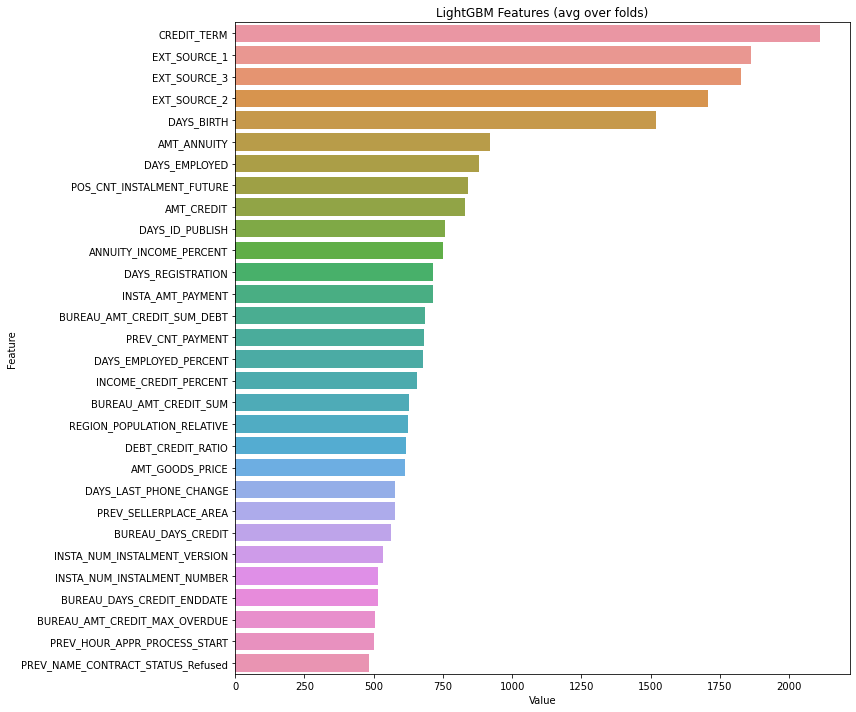

In [214]:
# now let's plot first 30 imp features

sns.barplot(x="Value", y="Feature", data=feature_imp.head(30).sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [215]:
y_pred = model_sk.predict(X_test_final)

In [217]:
accuracy_score(y_test, y_pred)

0.756953628026969

In [218]:
pd.crosstab(y_test, y_pred)

col_0,0,1
row_0,,
0,32443,9960
1,1251,2473


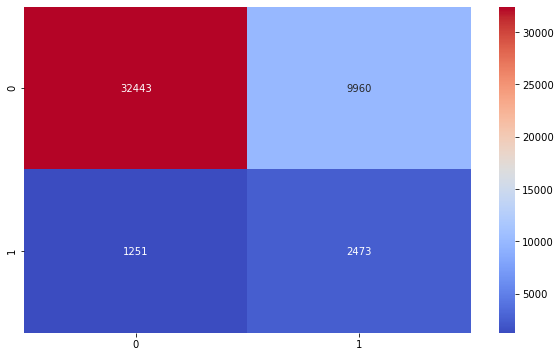

In [227]:
plt.figure(figsize=(10,6))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.5g', cmap='coolwarm');

In [228]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.77      0.85     42403
           1       0.20      0.66      0.31      3724

    accuracy                           0.76     46127
   macro avg       0.58      0.71      0.58     46127
weighted avg       0.90      0.76      0.81     46127



* From the above metrics, the model seems to be good with approximately 75% accuracy.
But this accuracy can be furth improved using feature selection techniques as there only 232 inportant features as per feature selection criteria used above. 
Also, using cross validation and hyperparameter tuning can be used to increase the accuracy but as the dataset is huge and time constraints are limited, I am submitting the task with above results.

In [229]:
from sklearn.ensemble import RandomForestClassifier

In [230]:
random_forest = RandomForestClassifier(max_depth=15)

In [231]:
random_forest.fit(trainFeatures, trainY)

RandomForestClassifier(max_depth=15)

In [232]:
y_pred = random_forest.predict(X_test_final)

In [233]:
accuracy_score(y_test, y_pred)

0.9192880525505669

In [234]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     42403
           1       1.00      0.00      0.00      3724

    accuracy                           0.92     46127
   macro avg       0.96      0.50      0.48     46127
weighted avg       0.93      0.92      0.88     46127



<AxesSubplot:>

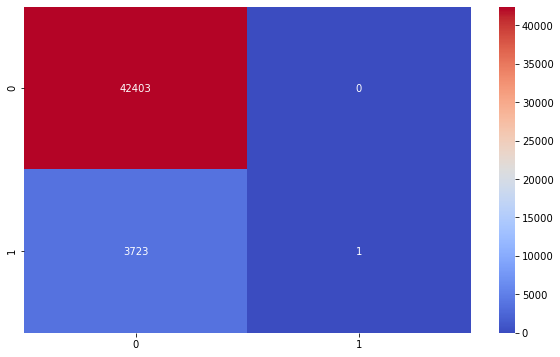

In [235]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt='.5g', cmap='coolwarm')

* From the above matrix, model seems to have overfitted.
* This can be reduced using hyperparameter tuning and cross validation along with feature selection techniques.

In [236]:
random_forest.feature_importances_

array([1.89475075e-03, 5.69856238e-03, 6.80736193e-03, 6.49962294e-03,
       6.24330631e-03, 5.75777347e-03, 1.15568205e-02, 1.11862856e-02,
       7.81896891e-03, 8.78501403e-03, 3.37002797e-03, 0.00000000e+00,
       5.99467782e-04, 7.32161123e-04, 8.14971718e-05, 7.38033571e-04,
       4.43610295e-04, 2.40359777e-03, 2.11801446e-03, 2.37693531e-03,
       5.10793651e-03, 3.73981954e-04, 4.57213089e-04, 4.04867889e-04,
       1.11497367e-03, 1.24439563e-03, 7.27057114e-04, 1.55662852e-02,
       4.62346296e-02, 3.71829076e-02, 3.21355444e-03, 2.50744039e-03,
       3.31556149e-03, 2.62193339e-03, 2.32135763e-03, 1.00405543e-03,
       2.00523252e-03, 1.76278665e-03, 1.19464258e-03, 2.62938680e-03,
       2.41403793e-03, 3.80350319e-03, 1.18762101e-03, 2.15222722e-03,
       3.32412106e-03, 2.34691014e-03, 3.49717656e-03, 2.52439056e-03,
       2.23966212e-03, 9.70305842e-04, 1.72355946e-03, 1.47781877e-03,
       1.21075148e-03, 2.47429387e-03, 2.44972740e-03, 3.56444309e-03,
      

In [237]:
feature_imp_forest = pd.DataFrame(zip(X_train_final.columns, random_forest.feature_importances_), columns=['Features', 'Value'])

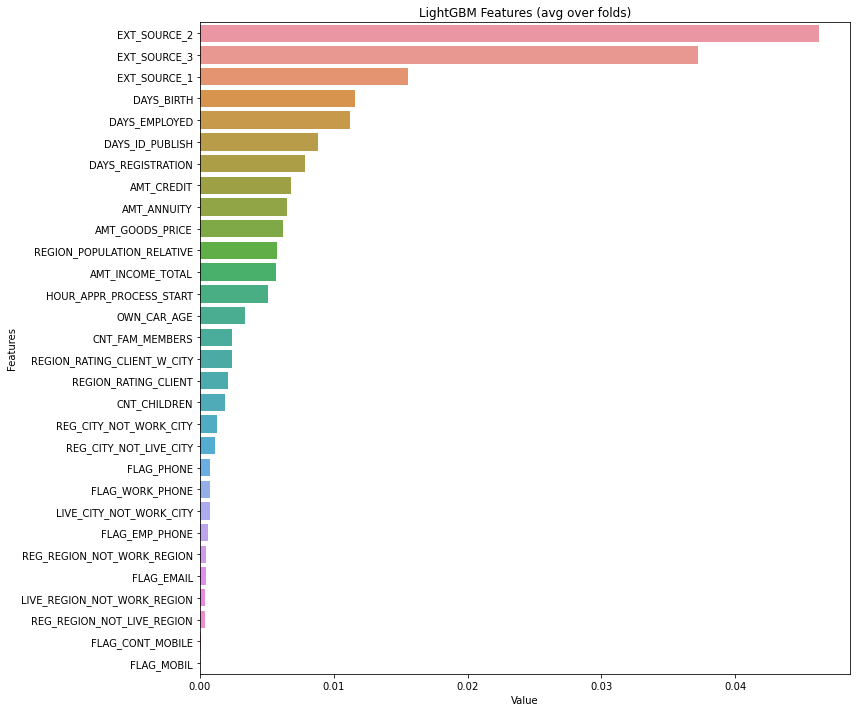

In [239]:
sns.barplot(x="Value", y="Features", data=feature_imp_forest.head(30).sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

### Conclusions:
* LightGBM gives poor accuracy of approx 75% but this can improved using feature selection and cross validation.
* Dataset is imbalanced. SMOTE (Synthetic Minority Oversampling Technique) can be used to make the dataset balanced. This created the datapoints of the minority class using Nearest Neighbour method. (This is not used here as this increases the size of dataset and system gets hung).

* Random Forest classifier algorithm is used to increase the accuracy. Accuracy has increased from 75% to 91% but the model seems to be overfitted after observing the confusion matrix for the random forest.
* Feature importance is plotted for both lightGBM and Random Forest. This feature imporance can be used to select the parameters for further improving the accuracy (I am submitting the task without this operations due to time constraint of two days).